In [1]:
import ee
from ipygee import *
import eeconvert
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
ee.Initialize()

In [3]:
import os,glob
g = os.getcwd()
g
path = 'D:\\repos\\CIAT\\IDB_PROJECT'
os.chdir(path)

In [4]:
def reflectance(image):
    return ee.Image(image.multiply(0.0001).copyProperties(image,["system:time_start"]))

def VI_L7(image):
    IVs = image.addBands(image.normalizedDifference(['B4', 'B3']).rename('NDVI'))
#     IVs = IVs.addBands(image.normalizedDifference(['B4', 'B5']).rename('NDRE'))
    IVs = IVs.addBands(image.normalizedDifference(['B4', 'B2']).rename('GNDVI'))
    IVs = IVs.addBands(image.normalizedDifference(['B2', 'B5']).rename('DNWVI'))
    IVs = IVs.addBands(image.normalizedDifference(['B5', 'B4']).rename('NWVI'))
    IVs = (IVs.addBands(image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B4'),
      'RED': image.select('B3'),
      'BLUE': image.select('B1')}).rename('EVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR * (1 - RED) * (NIR - RED))^(1/3)', {
      'NIR': image.select('B4'),
      'RED': image.select('B3')}).rename('AVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR - 2 * RED + BLUE)/(NIR + 2 * RED - BLUE)', {
      'NIR': image.select('B4'),
      'RED': image.select('B3'),
      'BLUE': image.select('B1')}).rename('ARVI')))
    IVs =( IVs.addBands(image.expression(
    'NIR/(NIR + RED)', {
      'NIR': image.select('B4'),
      'RED': image.select('B3'),}).rename('IPVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR-RED)/(NIR+RED + 0.16)', {
      'NIR': image.select('B4'),
      'RED': image.select('B3'),}).rename('OSAVI')))
    IVs = (IVs.addBands(image.expression(
    'GREEN - 0.39 * RED - 0.69 * BLUE', {
      'BLUE': image.select('B1'),
      'RED': image.select('B3'),
      'GREEN': image.select('B2'),}).rename('TGI')))
    return IVs

def VI_L8(image):
    IVs = image.addBands(image.normalizedDifference(['B5', 'B4']).rename('NDVI'))
#     IVs = IVs.addBands(image.normalizedDifference(['B4', 'B5']).rename('NDRE'))
    IVs = IVs.addBands(image.normalizedDifference(['B5', 'B2']).rename('GNDVI'))
    IVs = IVs.addBands(image.normalizedDifference(['B2', 'B6']).rename('DNWVI'))
    IVs = IVs.addBands(image.normalizedDifference(['B6', 'B4']).rename('NWVI'))
    IVs = (IVs.addBands(image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')}).rename('EVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR * (1 - RED) * (NIR - RED))^(1/3)', {
      'NIR': image.select('B5'),
      'RED': image.select('B4')}).rename('AVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR - 2 * RED + BLUE)/(NIR + 2 * RED - BLUE)', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),
      'BLUE': image.select('B2')}).rename('ARVI')))
    IVs =( IVs.addBands(image.expression(
    'NIR/(NIR + RED)', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),}).rename('IPVI')))
    IVs = (IVs.addBands(image.expression(
    '(NIR-RED)/(NIR+RED + 0.16)', {
      'NIR': image.select('B5'),
      'RED': image.select('B4'),}).rename('OSAVI')))
    IVs = (IVs.addBands(image.expression(
    'GREEN - 0.39 * RED - 0.69 * BLUE', {
      'BLUE': image.select('B2'),
      'RED': image.select('B4'),
      'GREEN': image.select('B3'),}).rename('TGI')))
    return IVs

def clouds_shadows_mask(image):
    qa = image.select('pixel_qa')
#   If the cloud bit (5) is set and the cloud confidence (7) is high
#   or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = (qa.bitwiseAnd(1 << 5)
             .And(qa.bitwiseAnd(1 << 7))
             .Or(qa.bitwiseAnd(1 << 3)))
#  emove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min())
    mask = image.updateMask(cloud.Not()).updateMask(mask2)
    return mask

In [6]:
def preprocessing(imageCollection,Cloud_masking = True, calculateReflectance = True, CalculateVIs = True, Landsat = 8):
    if Cloud_masking:
        images = imageCollection.map(clouds_shadows_mask)
    if calculateReflectance:
        images = images.map(reflectance)
    if CalculateVIs:
        if Landsat == 8:
            images = images.map(VI_L8)
        if Landsat == 7:
            images = images.map(VI_L7)
    return images

In [7]:
def ExtractFeatures(imageCollection,ROI,VIs=['NDVI','NDWI']):
    VI = imageCollection.select(VIs)
    ft = ee.FeatureCollection(ee.List([]))
    def fill(img, ft):
    #   // type cast
        inift = ee.FeatureCollection(ft)
    #   // gets the values for the points in the current img
        ft2 = img.reduceRegions(ROI, ee.Reducer.firstNonNull(),30)
    #   // gets the date of the img
        date = img.date().format()
        def function(f):
            return f.set("date", date)
    #   // writes the date in each feature
        ft3 = ft2.map(function)
    #   // merges the FeatureCollections
        return inift.merge(ft3)
    # // Iterates over the ImageCollection
    newft = ee.FeatureCollection(VI.iterate(fill, ft))
    gdf = eeconvert.fcToGdf(newft,crs={'init': 'epsg:4326'})
    del gdf['geometry'] #delete geometry column
    gdf["date"]= gdf["date"].str.split("T", n = 1, expand = True) 
    gdf['date'] = pd.to_datetime(gdf['date'], format='%Y-%m-%d')
    return gdf

In [ ]:
Points = gpd.read_file("Data_IDB/new/Zona_influencia_DR.shp")
ok = Points[Points['corregido'].str.contains("ok")]
# print(ok)
points = eeconvert.gdfToFc(ok)
points

In [14]:
L7 = (ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
      .filterBounds(points)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))# filter according to drawn boundary
      .filterDate('2011-01-01', '2011-01-15'))

In [15]:
# CAMPINAS = S2.map(clouds_shadows_mask)     
# CAMPINAS = CAMPINAS.map(VI)
DR_L7 = preprocessing(L7,Cloud_masking = True, calculateReflectance = False, CalculateVIs = False, Landsat = 7)
DR_L7

In [ ]:
L7_FE = ExtractFeatures(DR_L7,points,["B3"])

In [ ]:
# df_Campinas = df_Campinas.dropna() #delete NaN
# del df_Campinas["ID"] #delete geometry ID
df_copy = L7_FE

In [ ]:
s = df_copy.names
numbers = range(1, 11)
sequence = []
for number in numbers:
    a = "G" + str(number)
    s = s.replace(str(number),a)
s = s.replace(["Q6","Q7","Q8"],["C5","C6","C7"])
df_copy.names = s
df_copy

In [23]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook
import seaborn as sns
# sns.set_style("white")
rc={"font.weight":"bold",'figure.figsize':(30, 6),'axes.labelsize': 28, 
    'font.size': 28,'axes.titlesize': 28,'legend.fontsize': 18, 'axes.titlesize': 28,
   "lines.linewidth": 2.5,'font.sans-serif': "Times New Roman"}
# sns.set()
sns.set(style="white", rc=rc,font_scale = 1.8)
# sns.set_style("white")
# sns.set_context("paper",rc=rc,font_scale = 1.5)
DATE = pd.DataFrame({
    'inside':[
        '2020-03-14','2020-05-02','2020-06-21','2020-08-03'],
    'outside':[
        '2020-03-19','2020-05-07','2020-06-27','2020-08-08']
})

DATE['inside'] = pd.to_datetime(DATE['inside'], format='%Y-%m-%d')
DATE['outside'] = pd.to_datetime(DATE['outside'], format='%Y-%m-%d')


In [29]:
df1 = df_copy[df_copy["names"]=="G5"]
# df1 = df1[df1["VIs_value"]>=0.2]
df1 = pd.melt(df1,id_vars=['names', "date"],var_name ='VIs', value_name ='VIs_value') #organizate pandas

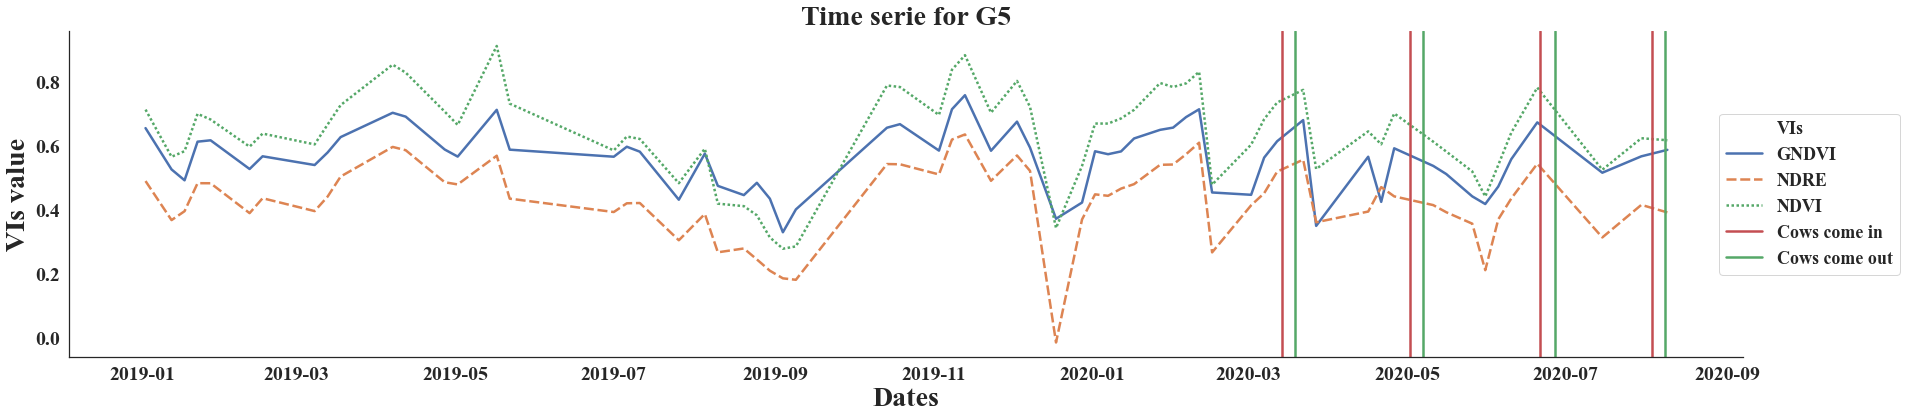

In [30]:
p = sns.lineplot('date', 'VIs_value', hue='VIs', style='VIs',
             data=df1)
p.set(xlabel='Dates', ylabel='VIs value',title="Time serie for G5")
for inside  in DATE.inside:
    p.axvline(inside,color='r',label="Cows come in")
for outside in DATE.outside:
    p.axvline(outside,color='g',label="Cows come out")
    
handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1)
sns.despine()
figure = p.get_figure()
# figure.savefig('Img/Sentinel/Campina/TS_G5-1.png', dpi=600)

In [68]:
PLOTS = gpd.read_file("data/Yotoco/PLOTS.shp")
Yotoco = eeconvert.gdfToFc(PLOTS)
Yotoco

In [69]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterDate('2019-01-01', '2020-08-15')
        .filterBounds(Yotoco))# filter according to drawn boundary

In [70]:
yotoco = preprocessing(S2)
yotoco

In [95]:
df_yotoco_S2 = ExtractFeatures(yotoco,Yotoco,["NDVI","NDRE","GNDVI","IPVI"])

In [96]:
df_yotoco_S2 = df_yotoco_S2.dropna()
df_copy = df_yotoco_S2
df_copy.head()

,FID,GNDVI,IPVI,NDRE,NDVI,date,names
0,2,0.669556,0.857292,0.591252,0.714585,2019-01-02,P 06
1,8,0.702087,0.894094,0.565787,0.788188,2019-01-02,P 14
2,11,0.704829,0.901462,0.565036,0.802925,2019-01-02,P 17
3,15,0.678966,0.882041,0.436977,0.764082,2019-01-02,P 21
4,4,0.682392,0.865937,0.569421,0.731874,2019-01-02,P 09


In [90]:
del df_copy['FID']
# df1 = df_copy[df_copy["names"]=="P6"]
# df1 = df1[df1["VIs_value"]>=0.2]
df1 = pd.melt(df_copy,id_vars=['names', "date"],var_name ='VIs', value_name ='VIs_value') #organizate pandas
df1.sort_values(by=['names'], inplace=True, ascending = True)
df1

,names,date,VIs,VIs_value
2366,P 05,2019-06-01,NDVI,0.564261
2438,P 05,2019-07-21,NDVI,0.450436
2592,P 05,2019-12-08,NDVI,0.777881
2424,P 05,2019-07-06,NDVI,0.793711
2217,P 05,2019-01-02,NDVI,0.865260
...,...,...,...,...
2379,P 22,2019-06-16,NDVI,0.816483
2623,P 22,2020-01-07,NDVI,0.748875
2397,P 22,2019-06-26,NDVI,0.679074
2555,P 22,2019-10-04,NDVI,0.310038


In [104]:
df2 = df1[df1["names"]=="P 05"]

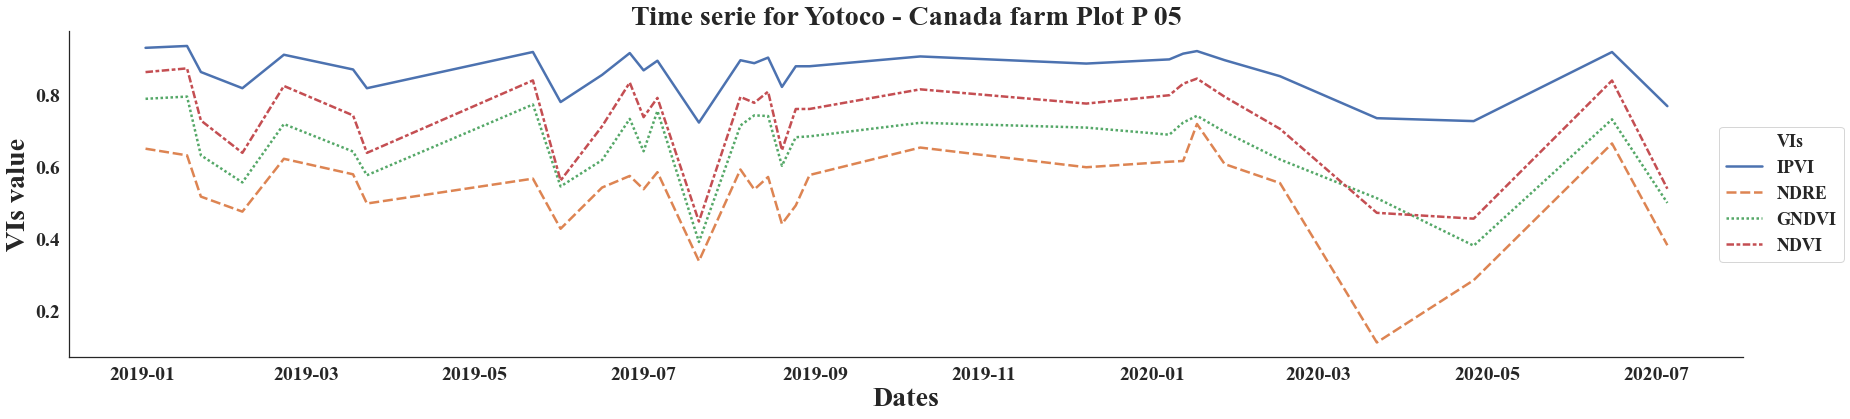

In [105]:
p = sns.lineplot('date', 'VIs_value', hue='VIs', style= "VIs",
             data=df2)
p.set(xlabel='Dates', ylabel='VIs value',title="Time serie for Yotoco - Canada farm Plot P 05")
# for inside  in DATE.inside:
#     p.axvline(inside,color='r',label="Cows come in")
# for outside in DATE.outside:
#     p.axvline(outside,color='g',label="Cows come out")
    
handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1)
sns.despine()
figure = p.get_figure()
# figure.savefig('Img/Sentinel/Yotoco/TS_P05_plots_S2.png', dpi=600)

In [82]:
S1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
      .filterDate('2019-01-01', '2020-08-15')
      .filterBounds(Yotoco)# filter according to drawn boundary
      .filter(ee.Filter.eq('instrumentMode', 'IW')))#filter type sensor

In [85]:
descVV = S1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
ascVV = S1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))

In [ ]:
# // remove the mountains from the data
hydrosheds = ee.Image('WWF/HydroSHEDS/03VFDEM');
terrain = ee.Algorithms.Terrain(hydrosheds);
slope = terrain.select('slope');
 
# // remove all slopes greater then 2 degrees
paddies = paddies.updateMask(slope.lt(2));

In [107]:
df_yotoco_S1 = ExtractFeatures(descVV,Yotoco,["VV","VH"])

C:\Users\fmontenegro\Miniconda3\envs\GEE\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [108]:
df_yotoco_S1 = df_yotoco_S1.dropna()
df_copy = df_yotoco_S1
df_copy.head()

,FID,VH,VV,date,names
0,2,-12.181261,-10.236330,2019-01-10,P 06
1,8,-19.279158,-11.577088,2019-01-10,P 14
2,11,-18.565371,-9.681735,2019-01-10,P 17
3,15,-19.729546,-14.092484,2019-01-10,P 21
4,4,-15.003788,-7.907963,2019-01-10,P 09


In [109]:
del df_copy['FID']
# df1 = df_copy[df_copy["names"]=="P6"]
df1 = pd.melt(df_copy,id_vars=['names', "date"],var_name ='VIs', value_name ='VIs_value') #organizate pandas
# df1 = df1[df1["VIs"]=="NDVI"]
df1.sort_values(by=['names'], inplace=True, ascending = True)
df1

,names,date,VIs,VIs_value
1679,P 05,2019-04-28,VV,-8.676467
1751,P 05,2019-09-07,VV,-10.850581
581,P 05,2020-05-04,VH,-14.915808
1769,P 05,2019-10-01,VV,-9.181714
2669,P 05,2019-12-30,VV,-9.715142
...,...,...,...,...
1574,P 22,2019-02-15,VV,-4.226377
674,P 22,2019-02-09,VH,-16.924292
2762,P 22,2020-02-28,VV,-11.871498
1682,P 22,2019-04-28,VV,-8.570255


In [112]:
df2 = df1[df1["names"]=="P 05"]

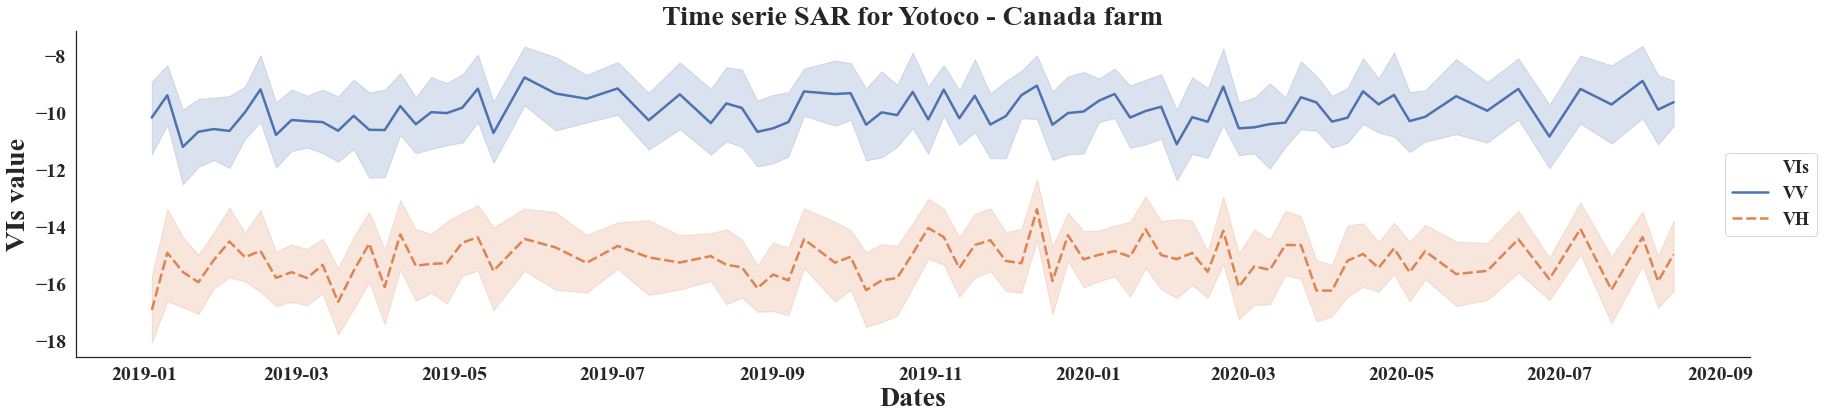

In [116]:
p = sns.lineplot('date', 'VIs_value', hue='VIs', style= "VIs",
             data=df1)
p.set(xlabel='Dates', ylabel='VIs value',title="Time serie SAR for Yotoco - Canada farm")
# for inside  in DATE.inside:
#     p.axvline(inside,color='r',label="Cows come in")
# for outside in DATE.outside:
#     p.axvline(outside,color='g',label="Cows come out")
    
handles, labels = p.get_legend_handles_labels()
lgd = dict(zip(labels, handles))
p.legend(lgd.values(), lgd.keys(),loc='center left', bbox_to_anchor=(0.98, 0.5), ncol=1)
sns.despine()
figure = p.get_figure()
figure.savefig('Img/Sentinel/Yotoco/TS_ALL_plots_S1.png', dpi=600)